In [17]:
import pandas as pd
import html5lib
import requests
import string
from bs4 import BeautifulSoup
import sqlite3 as lite
from pandas.io import sql

import numpy as np
from pandas import DataFrame, Series, read_csv
import matplotlib.pyplot as plt
import matplotlib 
import re
import itertools

# Enable inline plotting
%matplotlib inline

# Extend the Limit of rows
pd.options.display.max_rows = 150

In [18]:
url= 'http://www.acaloriecounter.com/fast-food.php'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html5lib')

In [19]:
# returns titles in a list named TABLE_TITLE.
TABLE_TITLE = []
for item in soup.find_all('h2'):
    TABLE_TITLE.append(item.text.rstrip('\n'))

# |REMOVING LAST TWO ROWS FROM THE TABLE TITLE LIST. #RETURNS COMPELTE LIST OF TITLE 
# |TABLES ON SITE.
TABLE_TITLE = TABLE_TITLE[:10]

# printing the results of the categories.
counter = 0
for title in TABLE_TITLE:
    counter += 1
    print ('Table #:| Category: ')
    print (counter,' :     ', title)
    print ('-'*70)
    print ('\n')

Table #:| Category: 
1  :      French Fries (Large) Compared
----------------------------------------------------------------------


Table #:| Category: 
2  :      Hamburgers Compared
----------------------------------------------------------------------


Table #:| Category: 
3  :      Sandwiches/Hamburgers Compared
----------------------------------------------------------------------


Table #:| Category: 
4  :      Chicken (Individual Pieces) Compared
----------------------------------------------------------------------


Table #:| Category: 
5  :      Chicken Sandwiches Compared
----------------------------------------------------------------------


Table #:| Category: 
6  :      Onion Rings Compared
----------------------------------------------------------------------


Table #:| Category: 
7  :      Breakfast Sandwiches/Biscuits/Croissants/Wraps Compared
----------------------------------------------------------------------


Table #:| Category: 
8  :      Mozzarella Sticks 

In [20]:
TABLE_CATEGORIES = ['Restaurants',
             'Type',
             'Serving_Size',
             'Calories',
             'Total_Fat',
             'Saturated_Fat',
             'Trans_Fat',
             'Carbs',
             'Sodium'
            ]

In [21]:
#Soup object returns all rows from all tables and saves the to a list.
TABLES_DATA = []
for tables in soup.find_all("table"):
    table = []
    for rows in tables.find('tbody'):
        for items in rows:
            for text in items:
                if text == ' ':
                    pass
                elif text == '\n':
                    pass
                elif text == '\t':
                    pass
                else:
                    table.append(text.replace('*', '').replace('\n', ''))
    TABLES_DATA.append(table)

    counter = 0

#displays the TABLE TITLE and corresponding first ROWS of the Table.
for table in TABLES_DATA:
    print ('\n')
    print ('Table : ', TABLE_TITLE[counter])
    print ('-'*70)
    counter += 1
    for row in table[:9]:
        print (row)
    



Table :  French Fries (Large) Compared
----------------------------------------------------------------------
McDonald's
Regular
170
570
30
6
8
70
330


Table :  Hamburgers Compared
----------------------------------------------------------------------
McDonald's
Regular
100
250
9
3.5
0.5
31
520


Table :  Sandwiches/Hamburgers Compared
----------------------------------------------------------------------
McDonald's
Quarter Pounder
169
410
19
7
1
37
730


Table :  Chicken (Individual Pieces) Compared
----------------------------------------------------------------------
McDonald's
Chicken McNuggets (6pc)
96
250
15
3
1.5
15
670


Table :  Chicken Sandwiches Compared
----------------------------------------------------------------------
McDonald's
McChicken
147
360
16
3.5
1
40
790


Table :  Onion Rings Compared
----------------------------------------------------------------------
Burger King (King Size)
150
500
25
5
4.5
62
720
A&W


Table :  Breakfast Sandwiches/Biscuits/Croissants/

In [22]:
Table_Names = ['Fries',
               'Hamburgers',
               'Sandwiches_Hamburger',
               'Chicken_Pieces',
               'Chicken_Sandwiches',
               'Onion_Rings',
               'Bkfst_Sandwiches',
               'Mozzarella_Sticks',
               'BreadSticks_CheesyBread',
               'Pizza_Large14'
              ]


In [23]:
def parse_table(table):
    results = []
    counter = 0
    table_row = []
    for row in table:
        try:
            table_row.append(float(row))
        except Exception as e:
            table_row.append(row)
        counter += 1
        if counter % 9 == 0:
            results.append(table_row)
            table_row = []
    return results

In [24]:
def easy_dataframe(table_list, table_catg):
    df_object = pd.DataFrame(table_list, columns = table_catg)
    return df_object.replace('Unknown', 0)

In [25]:
counter = 0
for item in Table_Names:
    exec('{} = easy_dataframe({},{})'.format(item.strip(),
                                             parse_table(TABLES_DATA[counter]),
                                             TABLE_CATEGORIES))
    counter += 1

In [26]:
#During this process, there is a discrepancy that must be handled so that all the tables are formated correctly
# Onion Rings does not have a Type column, and there it has not formated properly.
# Some additional parsing and custom function to solve this for ONION Rings at this point.
def parse_onions(table):
    results = []
    counter = 0
    table_row = []
    for row in table:
        try:
            table_row.append(float(row))
        except Exception as e:
            table_row.append(row)
        counter += 1
        if counter % 8 == 0:
            results.append(table_row)
            table_row = []
    return results

ONION_CATEGORIES = ['Restaurants',
             'Serving_Size',
             'Calories',
             'Total_Fat',
             'Saturated_Fat',
             'Trans_Fat',
             'Carbs',
             'Sodium'
            ]
Onion_Rings = easy_dataframe(parse_onions(TABLES_DATA[5]), ONION_CATEGORIES)

## Calorie Calcuation
Converting grams into calories for fat and and carb
    1gram fat = 9 calories
    1gram carb = 4 calories

Then finding the remaining calories which should be protien, then converting it into grams.
    1gram protien = 4 calories

In [27]:
def extra_columns(table):
    #Calorie conversion
    CarbsCal = table['Carbs'] * 4
    FatCal = table['Total_Fat'] * 9
    
    #finding protein
    TotalKnownCal = CarbsCal + FatCal
    ProteinCal = table['Calories'] - TotalKnownCal
    Protein = ProteinCal / 4
    
    #adding ratio in percentage
    CarbsRatio = (CarbsCal / table['Calories'])* 100
    FatRatio = (FatCal / table['Calories'])* 100
    ProteinRatio = (ProteinCal / table['Calories']) * 100
    
    #inserting rows
    table.insert(4,'Protein', Protein)
    table['Carb_Ratio'] = CarbsRatio
    table['Fat_Ratio'] = FatRatio
    table['Protein_Ratio'] = ProteinRatio 
    return table

## Adding Extra Tables
Here we are adding extra columns for the values we did the calculations above

In [28]:
Fries = extra_columns(Fries)
Hamburgers = extra_columns(Hamburgers)
Sandwiches_Hamburger = extra_columns(Sandwiches_Hamburger)
Chicken_Pieces = extra_columns(Chicken_Pieces)
Chicken_Sandwiches = extra_columns(Chicken_Sandwiches)
Onion_Rings = extra_columns(Onion_Rings)
Bkfst_Sandwiches = extra_columns(Bkfst_Sandwiches)
Mozzarella_Sticks = extra_columns(Mozzarella_Sticks)
BreadSticks_CheesyBread = extra_columns(BreadSticks_CheesyBread)
Pizza_Large14 = extra_columns(Pizza_Large14)

## Creating Reccommended Macro Nutrient Rule
This rule would apply to sandwiches and burgers as they would have the components to be a meal

Would not be applied to fries and mozzerala stick

In [29]:
def parse_series(series):
    results = []
    columns = []
    for index, row in series.iterrows():
        if row['Protein_Ratio'] < 25:
            if row['Fat_Ratio'] < 35:
                if row['Carb_Ratio'] < 50:
                    results.append((row['Restaurants'],
                                   row['Type'],
                                   #row['Serving_Size'],
                                   row['Calories'],
                                   row['Protein'],
                                   row['Total_Fat'],
                                   #row['Saturated_Fat'],
                                   #row['Trans_Fat'],
                                   row['Carbs'], 
                                   row['Sodium'],
                                   row['Carb_Ratio'],
                                   row['Fat_Ratio'],
                                   row['Fat_Ratio']))
    table_catgs = ['Restaurants',
                   'Type',
                   #'Serving_Size',
                   'Calories',
                   'Protein',
                   'Total_Fat',
                   #'Saturated_Fat',
                   #'Trans_Fat',
                   'Carbs',
                   'Sodium',
                   'Carb_Ratio',
                   'Fat_Ratio',
                   'Fat_Ratio']
    results = pd.DataFrame(results, columns = table_catgs )
    return results    


## Having a visual view of all the food choices available
In this view we will have Hamburgers, Sandwich Hamburgers, ChickenPieces, Chicken Sandwiches, Breakfast Sandwiches and Pizza.


In [52]:
df = pd.concat([Hamburgers, Sandwiches_Hamburger, Chicken_Pieces, Chicken_Sandwiches, Bkfst_Sandwiches, Pizza_Large14])
df

,Restaurants,Type,Serving_Size,Calories,Protein,Total_Fat,Saturated_Fat,Trans_Fat,Carbs,Sodium,Carb_Ratio,Fat_Ratio,Protein_Ratio
0,McDonald's,Regular,100,250,11.25,9,3.5,0.5,31,520,49.600000,32.400000,18.000000
1,Burger King,Regular,121,290,15.50,12,4.5,0.0,30,560,41.379310,37.241379,21.379310
2,Wendy's,Jr. Hamburger,0,230,13.50,8,3.0,0.0,26,500,45.217391,31.304348,23.478261
3,Hardee's,Regular,118,310,14.50,12,4.0,0.0,36,560,46.451613,34.838710,18.709677
4,Carl's Jr,Big Hamburger,209,470,25.25,17,6.0,0.0,54,1060,45.957447,32.553191,21.489362
5,Sonic,Jr. Burger,117,310,13.75,15,5.0,0.5,30,610,38.709677,43.548387,17.741935
6,White Castle,Regular,58,140,5.25,7,2.5,0.5,14,210,40.000000,45.000000,15.000000
7,Dairy Queen,Homestyle Burger,140,350,23.00,14,7.0,0.5,33,400,37.714286,36.000000,26.285714
8,Jack in the Box,Regular,118,310,16.00,14,6.0,1.0,30,600,38.709677,40.645161,20.645161
9,In-N-Out Burger,Regular,243,390,15.75,19,5.0,0.0,39,650,40.000000,43.846154,16.153846


## Figuring which food fits our macro beakdown
25% Protien, 35% Fat, 50% Carbs

In [53]:
FoodResult = parse_series(df)
FoodResult

,Restaurants,Type,Calories,Protein,Total_Fat,Carbs,Sodium,Carb_Ratio,Fat_Ratio,Fat_Ratio
0,McDonald's,Regular,250,11.25,9,31,520,49.600000,32.400000,32.400000
1,Wendy's,Jr. Hamburger,230,13.50,8,26,500,45.217391,31.304348,31.304348
2,Hardee's,Regular,310,14.50,12,36,560,46.451613,34.838710,34.838710
3,Carl's Jr,Big Hamburger,470,25.25,17,54,1060,45.957447,32.553191,32.553191
4,McDonald's,Premium Crispy Chicken Classic,500,25.75,17,61,1330,48.800000,30.600000,30.600000
5,Wendy's,Homestyle Chicken Fillet,430,23.50,16,48,1140,44.651163,33.488372,33.488372


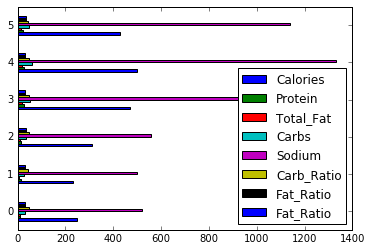

In [54]:
FoodResult.plot(kind='barh')

In [30]:
Fries

,Restaurants,Type,Serving_Size,Calories,Protein,Total_Fat,Saturated_Fat,Trans_Fat,Carbs,Sodium,Carb_Ratio,Fat_Ratio,Protein_Ratio
0,McDonald's,Regular,170,570,5.00,30,6.0,8.0,70,330,49.122807,47.368421,3.508772
1,Burger King,Regular,160,500,5.00,28,6.0,6.0,57,820,45.600000,50.400000,4.000000
2,Burger King,Salt Not Added,160,500,5.00,28,6.0,6.0,57,530,45.600000,50.400000,4.000000
3,Wendy's,Regular,0,540,7.50,26,4.0,1.0,69,550,51.111111,43.333333,5.555556
4,Arby's,Homestyle,213,566,-23.75,37,7.0,1.0,82,1029,57.950530,58.833922,-16.784452
5,Arby's,Curly,198,631,1.50,37,7.0,1.0,73,1476,46.275753,52.773376,0.950872
6,Hardee's,Regular,193,610,11.50,28,6.0,0.0,78,370,51.147541,41.311475,7.540984
7,Hardee's,Crispy Curls,153,480,8.25,23,6.0,0.0,60,1190,50.000000,43.125000,6.875000
8,A&W,Regular,156,430,6.00,18,4.5,5.5,61,640,56.744186,37.674419,5.581395
9,A&W,Chili,170,370,7.50,16,4.5,6.0,49,780,52.972973,38.918919,8.108108


In [39]:
Onion_Rings

,Restaurants,Serving_Size,Calories,Total_Fat,Protein,Saturated_Fat,Trans_Fat,Carbs,Sodium,Carb_Ratio,Fat_Ratio,Protein_Ratio
0,Burger King (King Size),150,500,25,6.75,5.0,4.5,62,720,49.600000,45.000000,5.400000
1,A&W,113,350,16,6.50,3.5,4.5,45,710,51.428571,41.142857,7.428571
2,Jack In The Box,119,500,30,6.50,6.0,10.0,51,420,40.800000,54.000000,5.200000
3,White Castle (Sack),178,410,20,4.50,5.0,7.0,53,400,51.707317,43.902439,4.390244
4,"White Castle (Homestyle, Sack)",178,790,44,7.50,8.0,30.0,91,860,46.075949,50.126582,3.797468
5,Sonic (Large),227,640,31,10.25,5.0,0.5,80,300,50.000000,43.593750,6.406250
6,Dairy Queen (Large),142,590,37,8.25,7.0,9.0,56,930,37.966102,56.440678,5.593220
7,Carl's Jr.,128,430,21,7.25,4.0,0.0,53,550,49.302326,43.953488,6.744186


In [41]:
Mozzarella_Sticks

,Restaurants,Type,Serving_Size,Calories,Protein,Total_Fat,Saturated_Fat,Trans_Fat,Carbs,Sodium,Carb_Ratio,Fat_Ratio,Protein_Ratio
0,Arby's,4 pc (Regular),137.0,426,5.50,28,13,1.0,38,1370,35.680751,59.154930,5.164319
1,Arby's,8 pc (Large),273.0,849,11.25,56,26,2.0,75,2730,35.335689,59.363958,5.300353
2,Jack In The Box,3 pc,71.0,240,12.00,12,5,2.0,21,420,35.000000,45.000000,20.000000
3,Jack In The Box,6 pc,138.0,483,21.00,27,11,4.0,39,1018,32.298137,50.310559,17.391304
4,White Castle,3 pc,79.2,250,9.00,14,6,2.0,22,750,35.200000,50.400000,14.400000
5,White Castle,5 pc,132.0,420,16.25,23,10,3.0,37,1240,35.238095,49.285714,15.476190
6,White Castle,10 pc,264.0,820,28.50,46,20,6.0,73,2490,35.609756,50.487805,13.902439
7,Sonic,0,140.0,440,20.50,22,9,0.5,40,1050,36.363636,45.000000,18.636364


In [42]:
BreadSticks_CheesyBread

,Restaurants,Type,Serving_Size,Calories,Protein,Total_Fat,Saturated_Fat,Trans_Fat,Carbs,Sodium,Carb_Ratio,Fat_Ratio,Protein_Ratio
0,Pizza Hut,Breadsticks,1 pc,150,4.00,6,1.0,0,20,230,53.333333,36.000000,10.666667
1,Pizza Hut,Cheese Breadsticks,1 pc,200,6.50,10,3.0,0,21,370,42.000000,45.000000,13.000000
2,Domino's Pizza,Breadsticks,1 pc,130,2.75,7,1.5,0,14,90,43.076923,48.461538,8.461538
3,Domino's Pizza,Cheesy Bread,1 pc,140,5.25,7,2.3,0,14,140,40.000000,45.000000,15.000000
4,Little Caesars,Crazy Bread,1 pc,100,3.25,3,0.5,0,15,150,60.000000,27.000000,13.000000
5,Little Caesars,Italian Cheese Bread,1 pc,130,3.75,7,2.5,0,13,230,40.000000,48.461538,11.538462
6,Little Caesars,Pepperoni Cheese Bread,1 pc,150,6.50,8,3.0,0,13,280,34.666667,48.000000,17.333333
7,Papa John's,Breadsticks,1 pc,140,4.50,2,0.0,0,26,260,74.285714,12.857143,12.857143
8,Papa John's,Cheesesticks,2 pc,370,14.50,16,4.5,0,42,830,45.405405,38.918919,15.675676


In [45]:
#CREATE DB
con1 = lite.connect("Final_Project.db")

cur = con1.cursor()


#DROP TABLE IF EXISTS:
cur.execute("DROP TABLE IF EXISTS Fries")
cur.execute("DROP TABLE IF EXISTS Hamburgers")
cur.execute("DROP TABLE IF EXISTS Sandwiches_Hamburger")
cur.execute("DROP TABLE IF EXISTS Chicken_Pieces")
cur.execute("DROP TABLE IF EXISTS Chicken_Sandwiches")
cur.execute("DROP TABLE IF EXISTS Onion_Rings")
cur.execute("DROP TABLE IF EXISTS Bkfst_Sandwiches")
cur.execute("DROP TABLE IF EXISTS Mozzarella_Sticks")
cur.execute("DROP TABLE IF EXISTS BreadSticks_CheesyBread")
cur.execute("DROP TABLE IF EXISTS Pizza_Large14")


#Insert Into Database ALL OF DATAFRAMES

sql.write_frame(Fries, name='Fries', con=con1)
sql.write_frame(Hamburgers, name='Hamburgers', con=con1)
sql.write_frame(Sandwiches_Hamburger, name='Sandwiches_Hamburger', con=con1)
sql.write_frame(Chicken_Pieces, name='Chicken_Pieces', con=con1)
sql.write_frame(Chicken_Sandwiches, name='Chicken_Sandwiches', con=con1)
sql.write_frame(Onion_Rings, name='Onion_Rings', con=con1)
sql.write_frame(Bkfst_Sandwiches, name='Bkfst_Sandwiches', con=con1)
sql.write_frame(Mozzarella_Sticks, name='Mozzarella_Sticks', con=con1)
sql.write_frame(BreadSticks_CheesyBread, name='BreadSticks_CheesyBread', con=con1)
sql.write_frame(Pizza_Large14, name='Pizza_Large14', con=con1)

#Close Connection
con1.close()

/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:22: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:23: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:24: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:25: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:26: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:27: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:28: FutureWarning: write_frame is deprecated, use to_sql
/Users/LightWeight/anaconda/lib/python3.4/site-packages

In [46]:
# TESTING DATABASE:
#CONNECTION:
con2 = lite.connect('Final_Project.db')
cur2 = con2.cursor()

#SQL COMMAND SELECTING TABLE
cur2.execute('SELECT * FROM Fries')

#FETCH ALL ROWS FROM TABLE
rows = cur2.fetchall()

#DISPLAY OF ROWS:
for row in rows:
    print (row, '    :Rows FROM|SQL TABLE')

#CLOSE SQL CONNECTION
con2.close()

("McDonald's", 'Regular', 170.0, 570.0, 5.0, 30.0, 6.0, 8.0, 70.0, 330.0, 49.122807017543856, 47.368421052631575, 3.508771929824561)     :Rows FROM|SQL TABLE
('Burger King', 'Regular', 160.0, 500.0, 5.0, 28.0, 6.0, 6.0, 57.0, 820.0, 45.6, 50.4, 4.0)     :Rows FROM|SQL TABLE
('Burger King', 'Salt Not Added', 160.0, 500.0, 5.0, 28.0, 6.0, 6.0, 57.0, 530.0, 45.6, 50.4, 4.0)     :Rows FROM|SQL TABLE
("Wendy's", 'Regular', 0.0, 540.0, 7.5, 26.0, 4.0, 1.0, 69.0, 550.0, 51.11111111111111, 43.333333333333336, 5.555555555555555)     :Rows FROM|SQL TABLE
("Arby's", 'Homestyle', 213.0, 566.0, -23.75, 37.0, 7.0, 1.0, 82.0, 1029.0, 57.95053003533569, 58.8339222614841, -16.784452296819786)     :Rows FROM|SQL TABLE
("Arby's", 'Curly', 198.0, 631.0, 1.5, 37.0, 7.0, 1.0, 73.0, 1476.0, 46.275752773375594, 52.77337559429477, 0.9508716323296356)     :Rows FROM|SQL TABLE
("Hardee's", 'Regular', 193.0, 610.0, 11.5, 28.0, 6.0, 0.0, 78.0, 370.0, 51.147540983606554, 41.31147540983607, 7.540983606557377)     :R